# Lecture 2 - Gradient descent

> A look at optimising functions with gradient descent

## Learning objectives

* Understand what stochastic gradient descent is and how to minimise functions with it in PyTorch

## References

* This notebook is a condensed version of Chapter 4 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger. We recommend reading that chapter in detail to get the full context.

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install fastai==2.6.0

## Imports

In [20]:
import torch
from fastai.tabular.all import *

## Stochastic gradient descent

What does it actually mean to _train_ a model? In deep learning, this process is called _stochastic gradient descent_ (SGD). As described in the fastai book, this process involves 7 main steps:

1. Initialize the parameters of the neural network
2. For each example in the dataset, use the parameters to make a predicition (e.g. is this jet produced by a top-quark or QCD background?)
3. Use these predictions to calculate the model performance via the _loss_
4. Calculate the _gradients_
5. Update all the parameters by taking a _step_ in the direction that minimises the loss
6. Repeat from step 2
7. Stop the training process once the model is good enough

In this lecture, we will take a deep dive into how these steps work in PyTorch. But before doing that, let's take a quick look at how gradients are computed in PyTorch, as they'll play a large role in what follows.

### Calculating gradients

To illustrate how gradients are computed in PyTorch, let's consider a simple quadratic loss function:

In [21]:
def f(x):
    return x**2

Next, let's create a tensor at the point we wish to calculate the gradient of $f(x)$:

In [24]:
xt = torch.tensor(3.0, requires_grad=True)
xt

tensor(3., requires_grad=True)

Here, the `requires_grad` argument tells PyTorch to begin recording operations on the tensor `xt`; in particular which parts of the code should be included for computing gradients. Next, let's use this tensor to generate the output `yt` from our function:

In [25]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

This looks good and here PyTorch is indicating both the value of the tensor and the gradient function that will be used. So let's now compute the gradients with the `backward()` method:

In [26]:
yt.backward()

Here, "backward" refers to _backpropagation_, which is the technique used in deep learning to compute the gradients of the loss with respect to all the parameters in the model. In this simple example we just have one parameter to consider, but in general, a neural network can have thousands to billions of parameters, and so an efficient method is needed to compute this many gradients efficiently.

Under the hood, PyTorch implements backprogations via an automatic differentiation engine called _autograd_ that keeps a record of tensors and all executed operations (like sum, multiplication etc) as a _directed acyclic graph_ (DAG). We'll look at backpropagation in a bit more detail later, but for now the main thing to note is that the gradients are stored in the `Tensor.grad` attribute:

In [27]:
xt.grad

tensor(6.)

Great, this worked since we know analytically that $f'(3) = 6$! Now let's generalise to the case where our tensor is an array of values:

In [28]:
xt = torch.tensor([3.0, 4.0, 10.0], requires_grad=True)
xt

tensor([ 3.,  4., 10.], requires_grad=True)

To compute the gradients, we'll also need to add a `sum()` operator to our function so that it returns a scalar:

In [29]:
def f(x):
    return (x**2).sum()


yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Here we can see that passing an array of values and applying the sum is equivalent to computing:

$$ f(x_0) = \sum_i x_i^2 \Big|_{x_0}  $$ 

Finally, let's check the values of our gradients $f'(x_0)$:

In [30]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Now that we know how to compute gradients, we next need to find a way to update all the weights. Let's take a look at this with a more realistic example.

## A toy example

Imagine that you're measuring some signal at fixed time steps:

In [31]:
time = torch.arange(0, 20).float()

and then find the result of your measurements looks something like a parabola:

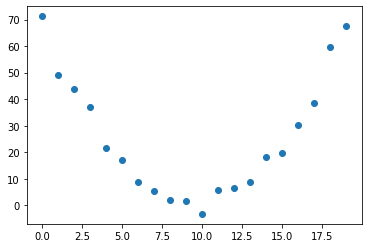

In [32]:
signal = torch.randn(20) * 3 + 0.75 * (time - 9.5) ** 2 + 1
plt.scatter(time, signal);

Using SGD, our goal will be to find a function that best fits the data. A good choice of function would be a general quadratic of the form:

$$ f(t, a,b,c) = at^2 + bt + c $$

We can then define a function that collects the timestep $t$ and the parameters $a,b,c$ as separate arguments:

In [33]:
def f(t, params):
    a, b, c = params
    return a * (t**2) + (b * t) + c

To define what we mean by "best" values of $a,b,c$, we'll need to choose a loss function. For regression problems like ours, it is common to use the mean squared error, which we can define as follows:

In [34]:
def mse(preds, targets):
    return ((preds - targets) ** 2).mean()

Now that we have a function we with to optimise and a loss function, let's work through the 7 steps of training a model.

### Step 1: Initialize the parameters

Since our function involves three parameters $a,b,c$, we'll initialise random values of them using the `torch.randn()` function:

In [48]:
set_seed(666)
params = torch.randn(3, requires_grad=True)
params

tensor([-2.1188,  0.0635, -1.4555], requires_grad=True)

As we did earlier, we've applied the `requires_grad_()` method to indicate that we wish to track the gradients of the `params` tensor. We've also set the seed to the number of the beast so that the results are reproducible when you run the code on your own machine 😈.

### Step 2: Calculate the predictions

The next step is compute the predictions from the "model":

In [49]:
preds = f(time, params)
preds.shape

torch.Size([20])

Notice that we get one prediction for each of the time step in the `time` array. We can visualise these predictions with the following helper function:

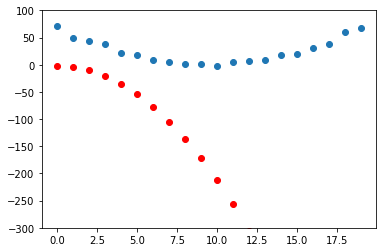

In [50]:
def show_preds(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, signal)
    ax.scatter(time, to_np(preds), color="red")
    ax.set_ylim(-300, 100)


show_preds(preds)

Unsuprisngly, our randomly initialised model isn't very good - let's see if we can improve it by adjusting the parameters!

### Step 3: Calculate the loss

To know how we should adjust the parameters, we need a way to indicate in which direction we should optimise them. To do so, we'll first compute the loss:

In [51]:
loss = mse(preds, signal)
loss

tensor(143791.4688, grad_fn=<MeanBackward0>)

To improve this value (i.e. make it lower), we'll need the gradients.

### Step 4: Calculate the gradients

Next we calculate the gradients:

In [52]:
loss.backward()
params.grad

tensor([-126908.2109,   -8142.3379,    -576.0350])

### Step 5: Step the weights

Next we need to update the parameters according to a learning rate. For now we'll just ues $10^{-5}$:

In [53]:
lr = 1e-5
params.data -= lr * params.data
params.grad = None

Let's check if the loss has improved:

In [54]:
preds = f(time, params)
mse(preds, signal)

tensor(143788.7812, grad_fn=<MeanBackward0>)

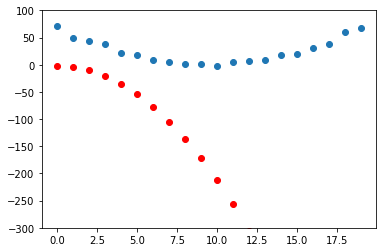

In [55]:
show_preds(preds)

Okay, not much of a change after one step so let's repeat the process a few times to see how things improve. To do so, we'll create another helper function that combines all of the above logic:

In [56]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, signal)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    return preds

### Step 6: Repeat the process

Now that we've done one step of gradient descent, it's time to repeat a few times to see if the loss decreases:

In [57]:
num_of_iterations = 10

for iteration in range(num_of_iterations):
    apply_step(params)

143788.78125
27754.04296875
5796.7294921875
1641.7310791015625
855.4754638671875
706.6890869140625
678.531494140625
673.2003173828125
672.1886596679688
671.9944458007812


Great, this seems to work! The loss is decreasing with each step, indicating that a different quadratic function is being tried with different values of the parameters $a,b,c$. We can visualise this process by plotting the intermediate results of the first few steps:

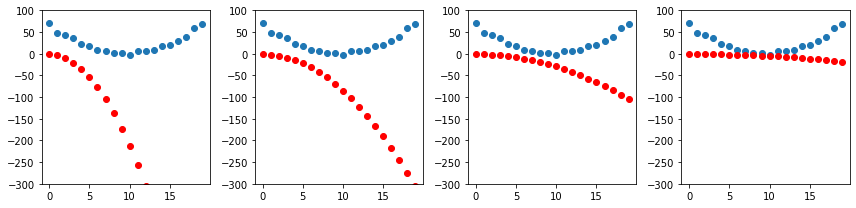

In [58]:
set_seed(666)
params = torch.randn(3).requires_grad_()

_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs:
    show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Step 7: Stop

Here we stopped the process after 10 steps, but in practice one would track metrics like accuracy and loss on the validation set to decide when is a good point to terminate the training.

All of these steps can be carried over to any deep learning problem, so next lecture we'll see how all these steps can be applied to the jet tagging datasets from lecture 1!

## Exercises

* Generate some random linear data and use SGD to find the best parameters for a linear regression model $\hat{y} = h_\theta(\bf{x}) = \bf{\theta}\cdot {\bf x} $